In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
code_path = "../src/"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [3]:
dataset = load("toy_data_3.jld")["data"]

AnomalyDetection.Dataset(Float32[0.803442 0.804605 … 0.252366 -0.216809; 0.821998 0.834235 … 0.714171 1.09756], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [4]:
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [5]:
# set problem dimensions
indim = size(X,1)
hiddendim = 4
latentdim = 2
nlayers = 3

# model constructor parameters
esize = [indim; hiddendim; hiddendim; latentdim]; # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim]; # decoder architecture
batchsize = 30 # batchsize
threshold = 0 # classification threshold, is recomputed when calling fit!
contamination = size(Y[Y.==1],1)/size(Y,1) # to set the decision threshold
iterations = 5000
cbit = 1000 # when callback is printed
nepochs = Int(ceil(batchsize*iterations/size(nX,2))) # if this is supplied, do epoch training
verbfit = true 
activation = Flux.relu
rdelta = 0.002 # reconstruction error threshold when training is stopped
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.history
eta = 0.0001

0.0001

In [6]:
# model might have to be restarted if loss is > 0.01
model = AEmodel(esize, dsize; batchsize = batchsize, threshold=threshold, 
    contamination=contamination, iterations=iterations, cbit=cbit, 
    nepochs = nepochs,
    verbfit=verbfit, activation = activation, rdelta = rdelta, 
    tracked = tracked, eta = eta)

AnomalyDetection.fit!(model, nX)
AnomalyDetection.setthreshold!(model, X)
AnomalyDetection.evalloss(model, nX)

Progress:   0%|                                         |  ETA: 4:11:08
Progress:  21%|█████████                                |  ETA: 0:00:14
Progress:  35%|██████████████                           |  ETA: 0:00:08
Progress:  49%|████████████████████                     |  ETA: 0:00:05
Progress:  63%|██████████████████████████               |  ETA: 0:00:03
Progress:  77%|████████████████████████████████         |  ETA: 0:00:01
Progress:  91%|█████████████████████████████████████    |  ETA: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
  loss:  0.057884656


loss: 0.06142811



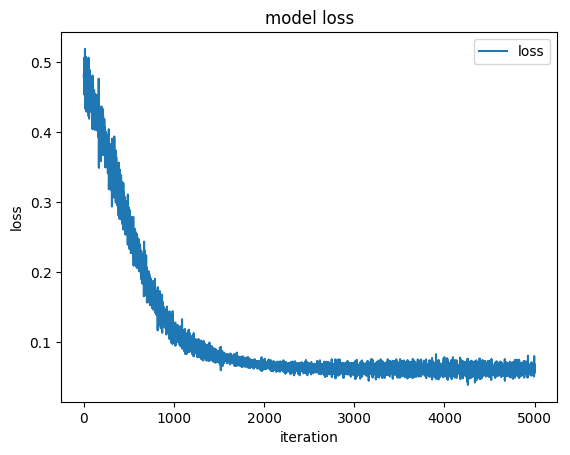

In [7]:
plot(model)
show()

In [8]:
model(nX)

Tracked 2×90 Array{Float32,2}:
 0.499314  0.500716  0.499991  0.50315   …  0.468518  0.473787  0.470506
 0.862985  0.866591  0.864726  0.872845     0.783829  0.797372  0.78894 

In [9]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [10]:
model(X)

Tracked 2×103 Array{Float32,2}:
 0.499314  0.500716  0.499991  0.50315   …  0.531584  0.453648  0.466457
 0.862985  0.866591  0.864726  0.872845     0.954107  0.745608  0.778531

In [11]:
X

2×103 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  -0.00703644  0.252366  -0.216809
 0.821998  0.834235  0.826129  0.848182      1.6113      0.714171   1.09756 

In [12]:
# predict labels
yhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 0
 1
 1
 1
 0
 1
 1
 0
 1

In [13]:
# training data = testing data
# this outputs labels
tryhat, tsthat, _, _ = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 9
  tn = 86
  fp = 4
  fn = 4
precision: 0.6923076923076923
f1score: 0.6923076923076923
recall: 0.6923076923076923
false positive rate: 0.044444444444444446
equal error rate: 0.17606837606837608

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 9
  tn = 86
  fp = 4
  fn = 4
precision: 0.6923076923076923
f1score: 0.6923076923076923
recall: 0.6923076923076923
false positive rate: 0.044444444444444446
equal error rate: 0.17606837606837608


In [14]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

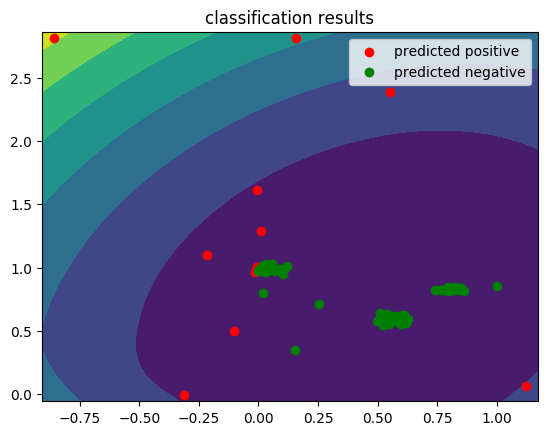

In [15]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

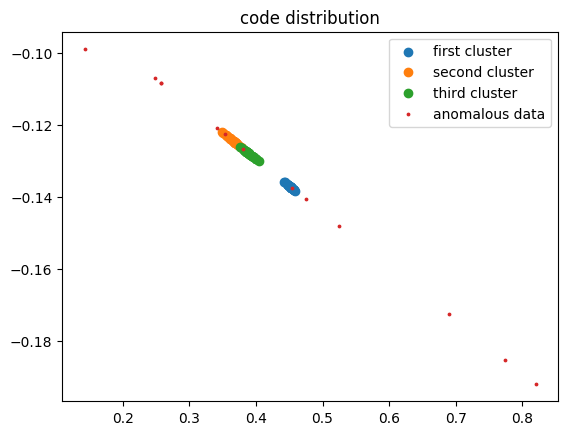

In [16]:
# what are the codes?
z1 = model.ae.encoder(X[:,1:30]).data
z2 = model.ae.encoder(X[:,31:60]).data
z3 = model.ae.encoder(X[:,61:90]).data
za = model.ae.encoder(X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

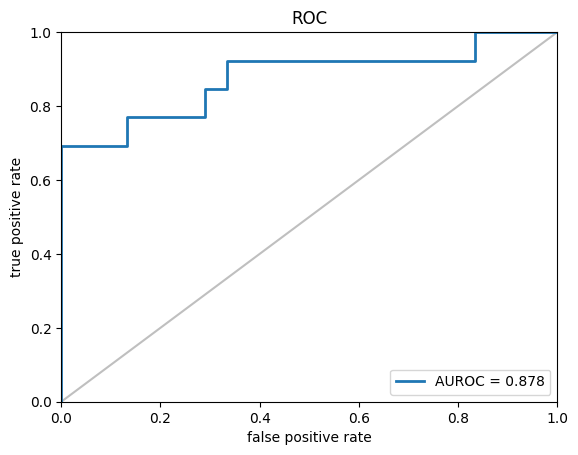

In [17]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()